In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Load dataset
df = pd.read_csv("../data/ObesityDataSet_Clean.csv")  

# Quick look at dataset
df.head()

target = "Weight"
feature_cols = ["Age", "Height", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

# define target and features (just to extract y)
y = df[target].to_numpy()
print(y)

# baseline ignores X, but we still need to split the same way
X = df[feature_cols].copy()
print(X)


[ 64.   56.   77.  ... 133.7 133.3 133.5]
      Age  Height  FCVC  NCP  CH2O  FAF  TUE
0      21    1.62     2    3     2    0    1
1      21    1.52     3    3     3    3    0
2      23    1.80     2    3     2    2    1
3      27    1.80     3    3     2    2    0
4      22    1.78     2    1     2    0    0
...   ...     ...   ...  ...   ...  ...  ...
2106   21    1.71     3    3     2    2    1
2107   22    1.75     3    3     2    1    1
2108   23    1.75     3    3     2    1    1
2109   24    1.74     3    3     3    1    1
2110   24    1.74     3    3     3    1    1

[2111 rows x 7 columns]


*BASELINE*

*LINEAR REGRESSION*

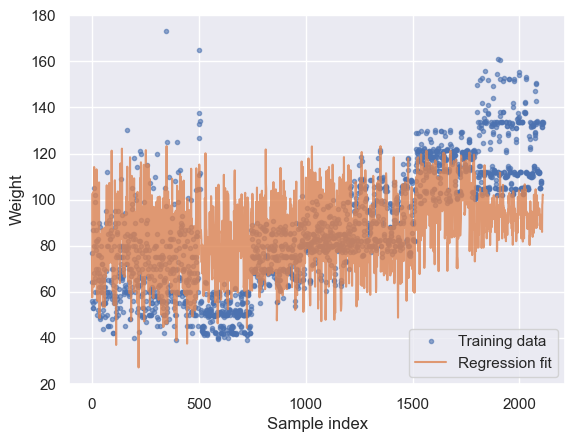

In [16]:


model = LinearRegression(fit_intercept=True)
model = model.fit(X, y)
y_est = model.predict(X)

# Plotting training targets and the regression predictions.
# Use sample index on the x-axis because X is a dataframe with multiple features.
x_idx = np.arange(len(y))

f = plt.figure()
plt.plot(x_idx, y, ".", alpha=0.6)
plt.plot(x_idx, y_est, "-", alpha=0.8)
plt.xlabel("Sample index")
plt.ylabel("Weight")
plt.legend(["Training data", "Regression fit"])
plt.show()


*NEURAL NETWORKS*

*TWO LAYER CROSS VALIDATION*

In [ ]:
def cross_validation(X, y, outer_folds=10, inner_folds=10, random_state=42):

    # Ensure y is a pandas Series so .iloc works (the notebook's y was a numpy array)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    rows = []
    CV_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
    fold_results = []  # store per-fold feature paths & errors
    outer_test_mse = []
    CV_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
    inner_mse = []

    # use enumerate to have a valid outer fold index
    for outer_fold_idx, (outer_train_idx, outer_test_idx) in enumerate(CV_outer.split(X), start=1):
        X_train_outer, X_test_outer = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train_outer, y_test_outer = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[inner_train_idx]
            X_test_inner = X_train_outer.iloc[inner_test_idx]
            y_train_inner = y_train_outer.iloc[inner_train_idx]
            y_test_inner = y_train_outer.iloc[inner_test_idx]

            # BASELINE MODEL
            baseline_pred = np.mean(y_train_inner)
            inner_mse.append(mean_squared_error(y_test_inner, [baseline_pred] * len(y_test_inner)))
            # ensure we pass an array-like of the same length as y_test_outer
            E_test_base = mean_squared_error(y_test_outer, [baseline_pred] * len(y_test_outer))
                            
            # LINEAR REGRESSION MODEL
            model = LinearRegression()
            model.fit(X_train_inner, y_train_inner)
            y_pred_inner = model.predict(X_test_inner)
            inner_mse.append(mean_squared_error(y_test_inner, y_pred_inner))
            E_test_lin = mean_squared_error(y_test_outer,  model.predict(X_test_outer))
            
            rows.append({"Outer fold": outer_fold_idx,  "E_test^lin": E_test_lin, "E_test^base": E_test_base})

    results = pd.DataFrame(rows).sort_values("Outer fold").reset_index(drop=True)
    print(results.round({"E_test^lin":2, "E_test^base":2}))
    print("\nAverages (MSE ↓) across outer folds:")
    print(f"Linear regression: {results['E_test^lin'].mean():.2f}")
    print(f"Baseline:          {results['E_test^base'].mean():.2f}")

    return results

_ = cross_validation(X, y, outer_folds=10, inner_folds=10, random_state=42)


    Outer fold  E_test^lin  E_test^base
0            1      461.93       732.29
1            1      460.02       732.48
2            1      462.89       732.31
3            1      463.17       732.32
4            1      463.15       732.41
..         ...         ...          ...
95          10      453.32       665.88
96          10      453.57       667.44
97          10      452.31       666.67
98          10      454.66       670.15
99          10      453.19       667.70

[100 rows x 3 columns]

Averages (MSE ↓) across outer folds:
Linear regression: 450.15
Baseline:          686.54
